In [ ]:
# 설명듣고 주석 달고 코드를 직접 짜보는 식으로..  
# colab 에서 진행 
# local에서 해도 됨.. 

# The Oxford-IIIT Pet Dataset
- https://www.robots.ox.ac.uk/~vgg/data/pets/
- 37개 카테고리의 개, 고양이 품종 데이터셋. 각 클래스 별로 대략 200여장의 이미지를 제공한다.
- 파일명에 품종이 포함되어 있어 classification 데이터셋을 만들 수 있다.
- 3686개 이미지에대한 annotation 파일을 제공한다.
    - bounding box는 각 pet의 얼굴을 가리킨다. 

In [40]:
# library import
import os
 
import re
import random
import xml.etree.ElementTree as et # xml에서 필요한 값들 추출하기위한 (함수어노테이션에 있는 값들을 읽기위해)
from PIL import Image
 
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle 
 
print(tf.__version__)
print(keras.__version__)

2.4.1
2.4.0


# Oxford Pet Dataset
- 파일명
    - 품종명_번호.jpg
    - 대문자로 시작: 고양이, 소문자로 시작: 개
    - Egyptian_Mau_1.jpg, american_bulldog_10.jpg

### 데이터셋 다운로드

In [41]:
#!pip install gdown  설치후 밑에꺼 실행해서 다운로드..

In [42]:
import gdown
url = 'https://drive.google.com/uc?id=1gXqmWrxJqdp_luNKZmv81vY5cjFLuTdT'
fname = 'oxford_pet.zip'
gdown.download(url, fname, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1gXqmWrxJqdp_luNKZmv81vY5cjFLuTdT
To: /content/oxford_pet.zip
811MB [00:06, 127MB/s]


'oxford_pet.zip'

첫글자 대문자 - 고양이 품종
소문자 - 강아지 품종

In [43]:
# !rm -r oxford_pet  

In [44]:
## 압축풀기 - 리눅스 명령어로 압축풀기
# unzip 압축파일 -d 압출풀 디렉토리  // -q는 로그 안남기려고.. 
!unzip -q oxford_pet.zip -d oxford_pet # 디렉토리가 없으면 자동으로 만들어줌..

replace oxford_pet/annotations/._trimaps? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [45]:
## 압축이 풀린 directory 확인  / 리눅스 기반이라 ls// 폴더안에 어떤 디렉토리, 파일들이 있나..
!ls -al oxford_pet

total 292
drwxr-xr-x 5 root root   4096 May 12 12:56 .
drwxr-xr-x 1 root root   4096 May 12 13:31 ..
drwxr-xr-x 4 root root   4096 May 12 13:33 annotations
drwxr-xr-x 2 root root 282624 May 12 13:33 images
drwxr-xr-x 2 root root   4096 May 12 12:57 tfrecord


In [46]:
# 경로 설정
base_dir = '/content/oxford_pet' #데이터셋 기본경로
image_dir = os.path.join(base_dir, 'images') # image 디렉토리 경로
bbox_dir = os.path.join(base_dir, 'annotations', 'xmls') #annotation 파일경로
print(base_dir, image_dir, bbox_dir)

/content/oxford_pet /content/oxford_pet/images /content/oxford_pet/annotations/xmls


In [ ]:
os.listdir(image_dir) # 이미지 디렉토리에 있는 이미지파일들의 파일 이름리스트 들이 나온다...

In [48]:
# os.path.splitext(fname)[-1] == '.jpg' -> 확장자만 짤라서..
os.path.splitext("test.jpg")[-1]

'.jpg'

In [49]:
# 이미지 파일명 조회
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
 # 파일명 .jpg만 리스트로 생성.  --> 그냥 jpg 로 하면 안됨 .jpg로 해야함
print(len(image_files))
 
image_files[:3]

7390


['german_shorthaired_109.jpg', 'leonberger_110.jpg', 'Russian_Blue_20.jpg']

In [50]:
#annotation 파일 경로 / #xml파일명만 조회해서 리스트로 생성. --> xml 이 어노테이션 확장자니까.. 
# os.listdir(bbox_dir) -> bbox_dir 에 있는 파일 리스트 들의 파일명이 나오니까 확장자 .xml 만 걸렀다.
bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] == '.xml']
print(len(bbox_files))
bbox_files[:3]  # 어노테이션이 없는 이미지 (파일)은 classification으로 만 사용해라~/ 어노테이션 명과,이미지파일명 같음.. 

3686


['boxer_178.xml', 'saint_bernard_123.xml', 'english_setter_142.xml']

In [51]:
# 이미지 파일중 RGB(컬러)가 아닌 이미지 파일과 그 파일에 대한 annotation파일 제거/-> pillow 사용해서 삭제 -> 더편함.
remove_image_cnt = 0
for image_file in image_files: # jpg 만 걸러낸 이미지 파일 리스트 
    # 이미지파일과 그에 매핑 되는 annotation 파일 경로 조회
    image_path = os.path.join(image_dir, image_file)
    bbox_file = os.path.splitext(image_file)[0]+'.xml'  #이미지 파일명에서 ->splitext이용해서  파일의 이름만 뽑음
    bbox_path = os.path.join(bbox_dir, bbox_file)
    
    image = Image.open(image_path) # 이미지파일 읽기
    image_mode = image.mode # 어떤 색공간을 갖고 있는지 .. 이미지 색공간을 string으로 반환 ..필로우 자체 타입으로 
    if image_mode != 'RGB': # RGB가 아니면 파일 삭제.
        image = np.asarray(image)
        print(image_file, image_mode, image.shape)

        os.remove(image_path) # 경로에 파일 이름까지 있음!/ 파일 삭제  (이미지 삭제 )
        remove_image_cnt += 1
        try:
            os.remove(bbox_path) # xml annotation 파일이 없는 경우 remove()에서 예외 발생하므로 예외 처리함..
            print(bbox_path)
        except FileNotFoundError:
            pass

# Egyptian_Mau_191.jpg P (214, 300) : P(색공간을 string으로 준것) -> gif 파일 

Egyptian_Mau_14.jpg RGBA (800, 582, 4)
Egyptian_Mau_129.jpg L (325, 299)
/content/oxford_pet/annotations/xmls/Egyptian_Mau_129.xml
Egyptian_Mau_145.jpg P (188, 216)
Abyssinian_5.jpg RGBA (150, 200, 4)
Egyptian_Mau_167.jpg P (275, 183)
staffordshire_bull_terrier_2.jpg L (282, 500)
Egyptian_Mau_177.jpg P (175, 246)
Egyptian_Mau_191.jpg P (214, 300)
Abyssinian_34.jpg P (202, 250)
staffordshire_bull_terrier_22.jpg L (500, 364)
Egyptian_Mau_186.jpg RGBA (275, 183, 4)
Egyptian_Mau_139.jpg P (250, 350)


In [52]:
remove_image_cnt # xml 은 1개 나머지  / 이미지..

12

In [53]:
# 삭제후 image, annotation 파일 목록 다시만들기
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] == '.xml']

In [54]:
len(image_files), len(bbox_files)

(7378, 3685)

### class dictionary 생성

In [55]:
# 클래스 딕셔너리 리스트로 만들기 / 파일명이 품종_숫자 니까 품종만 남기고 다 삭제 ..
 
#Egyptian_Mau_167.jpg / 품종_숫자.jpg
class_list = set() # set : 중복허용 안하고 
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]   # 파일 명만 추출 --> 품종_숫자를 분리.
    class_name = re.sub('_\d+', '', file_name) # 파일명에서 숫자만 제거 정규표현식이용해서  --> 품종_숫자를 분리
    class_list.add(class_name)    
class_list = list(class_list)  # set을 list로 바꿈.. 정렬
class_list.sort()  
print(len(class_list))

37


In [56]:
class_list[:5],class_list[-5:]  

(['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair'],
 ['scottish_terrier',
  'shiba_inu',
  'staffordshire_bull_terrier',
  'wheaten_terrier',
  'yorkshire_terrier'])

In [57]:
predict_result =3  # 예측 된 값이 3일때
class_list[3]

'Bombay'

In [58]:
# 리스트 딕셔너리로 만들기: class->index로 반환하는 것.
class2idx = {cls:idx for idx, cls in enumerate(class_list)} #-> 
#class2idx

In [59]:
class2idx['Bombay'] 

3

# train/validation 데이터셋 만들기

## TFRecord 만들기

In [60]:
#bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] == '.xml']

In [61]:
IMG_SIZE = 224  # resize 크기 
N_BBOX = len(bbox_files) # annotation 파일이 있는 데이터 셋만 사용할거라서 -> 전체 데이터 개수 / bboxfile 이있는게 annotation 
N_TRAIN = 3000 # train set의 개수
N_VAL = N_BBOX - N_TRAIN  # validation set의 개수

In [62]:
## TFRecord 저장할 directory 생성
tfr_dir = os.path.join(base_dir, 'tfrecord')
os.makedirs(tfr_dir, exist_ok=True) #exist_ok=True  디렉토리 있으면 안만들고 에러도 안낸다..

tfr_train_dir = os.path.join(tfr_dir, 'oxford_train.tfr')  #train set 을 저장할 tfrecord파일 경로
tfr_val_dir = os.path.join(tfr_dir, 'oxford_val.tfr') # validation set 을 저장할 tfrecord 파일 경로

In [63]:
## TFRecord writer 생성  // 역직렬화 할때 사용할 ..  객체 생성
writer_train = tf.io.TFRecordWriter(tfr_train_dir) # 경로의 oxford_train.tfr파일에 저장할거야
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [64]:
# The following functions can be used to convert a value to a type compatible with tf.Example.
# 값을 Feature로 변환하는 함수. //파이선데이터 타입을 feature값으로 변환
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
 
def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
 
def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [65]:
# train, validation 데이터셋의 index 설정

# 데이터 섞기 -> 인덱스 번호들만 섞어서.. 분할 해주고 밑에 train TFRecord 만들때 사용한다.
shuffle_list = list(range(N_BBOX)) # [1,2,3,4,5,...,3600]인덱스 번호 ..  알파벳 순서라서 섞음.. 
random.shuffle(shuffle_list) # 인덱스 섞일것임.
# 분할 - index
train_idx_list = shuffle_list[:N_TRAIN]  # 0~2999개 train
val_idx_list = shuffle_list[N_TRAIN:]   # 3000~ 개  validation

In [66]:
# Train TFRecord 생성
for idx in train_idx_list:
    bbox_file = bbox_files[idx]
    bbox_path = os.path.join(bbox_dir, bbox_file)
  
    #annotation (root태그) - size - width, height
    #annotation - object -bndbox - xmin,xmax,ymin,ymax
    # et.parse를 이용해서 xml 형태의 anotation 파일에 있는 내용 추출
    tree = et.parse(bbox_path) # xml 파일 경로, treednlcl :root 태그 
    width = float(tree.find('./size/width').text) # 어노테이션에서의 값을 갖고 찾아내는것임
    height = float(tree.find('./size/height').text) # .text - tag 내의 내용을 answkduf (string)반환
    xmin = float(tree.find('./object/bndbox/xmin').text) # float 사용해서 실수로 다 바꿔줌//..
    ymin = float(tree.find('./object/bndbox/ymin').text)
    xmax = float(tree.find('./object/bndbox/xmax').text)
    ymax = float(tree.find('./object/bndbox/ymax').text)
    #X, Y Center 좌표  / 이미지 사이즈를 resize 할것이니까 비율로 알려 주려고 했다.
    xc = (xmin + xmax) / 2.
    yc = (ymin + ymax) / 2.
   # 비율을 구했다는 것..을 정규화 시켰다고 생각하면 된다. 비율이니까  0 ~1 사이의 값으로 다 변환 됐을 것이다. 
    x = xc / width #(600,400) 이미지 이니까 width 600으로 나눠서 센터 좌표 비율을 구했다. 
    y = yc / height
    # 비율로 전달할 거라서 ... 
    w = (xmax - xmin) / width # w는 박스의 width --> 비율 구함.. 
    h = (ymax - ymin) / height # h는 박스의 height

    # 이미지 파일
    file_name = os.path.splitext(bbox_file)[0]
    image_file = file_name + '.jpg' # 이미지 파일명
    image_path = os.path.join(image_dir, image_file) # 이미지 경로 + 이미지 파일명 => 이미지 경로
    image = Image.open(image_path) # 이미지 파일 읽기 
    image = image.resize((IMG_SIZE, IMG_SIZE)) # (244,244) 로 resize
    bimage = image.tobytes() # 이미지를 bytes 타입으로 변환해야 feature값으로 바꾸니까..

    # 품종 라벨 -> labelEncording /-> 참고로.. 
    class_name = re.sub('_\d+', '', file_name)
    class_num = class2idx[class_name]  # 품종을 넣으면 인덱스? 번호가 들어감 
    
    # 개/고양이 (이진분류) 라벨 -> LabelEncording (개- 소문자  :0 , 고양이- 대문자 시작:1)
    if file_name[0].islower(): # 첫 글자가 소문자냐? 고 물어보는 코드
        bi_cls_num = 0
    else:
        bi_cls_num = 1
    
    #Example : 데이터 1개 -> 여러개 Feature들
    example = tf.train.Example(features=tf.train.Features(feature={
          'image': _bytes_feature(bimage),      # 바이츠타입으로 바꾼 이미지 파일 넣어서 feature타입으로 변환 
          'cls_num': _int64_feature(class_num), # 라벨 - 품종라벨 (정수로 변환된 -0~36)
          'bi_cls_num': _int64_feature(bi_cls_num), # 라벨 - 개/고양이 (정수로 변환된 0:dog, 1:cat)
          'x': _float_feature(x), #bbox center x 좌표
          'y': _float_feature(y), #bbox center y좌표
          'w': _float_feature(w), # bbox width
          'h': _float_feature(h)  # bbox height
    })) # 주피터 노트북에서는 따로 딕셔너리를 만들어서 넣어줬었는데 여기서는 직접 넣어줌
    writer_train.write(example.SerializeToString()) # Serialize를 통해 바이츠로 바꿔서 tfrecord 파일에 출력

writer_train.close()

In [67]:
# Validation TFRecord 생성
for idx in val_idx_list:
    bbox_file = bbox_files[idx]
    bbox_path = os.path.join(bbox_dir, bbox_file)
 
    tree = et.parse(bbox_path)
    width = float(tree.find('./size/width').text)
    height = float(tree.find('.size/height').text)
    xmin = float(tree.find('./object/bndbox/xmin').text)
    ymin = float(tree.find('./object/bndbox/ymin').text)
    xmax = float(tree.find('./object/bndbox/xmax').text)
    ymax = float(tree.find('./object/bndbox/ymax').text)
    xc = (xmin + xmax) / 2.
    yc = (ymin + ymax) / 2.
    x = xc / width
    y = yc / height
    w = (xmax - xmin) / width
    h = (ymax - ymin) / height
 
    file_name = os.path.splitext(bbox_file)[0]
    image_file = file_name + '.jpg'
    image_path = os.path.join(image_dir, image_file)
    image = Image.open(image_path)
    image = image.resize((IMG_SIZE, IMG_SIZE))
    bimage = image.tobytes()
 
    class_name = re.sub('_\d+', '', file_name)
    class_num = class2idx[class_name]
 
    if file_name[0].islower():
        bi_cls_num = 0
    else:
        bi_cls_num = 1
    
    
    example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),
      'cls_num': _int64_feature(class_num),
      'bi_cls_num': _int64_feature(bi_cls_num),
      'x': _float_feature(x),
      'y': _float_feature(y),
      'w': _float_feature(w),
      'h': _float_feature(h)
    }))
    writer_val.write(example.SerializeToString())

writer_val.close()

In [68]:
# -------------------------여기 까지 했음

# Localization 모델 학습

In [29]:
## Hyper Parameters
LEARNING_RATE = 0.0001
N_CLASS = len(class_list)
N_EPOCHS = 40
N_BATCH = 40
IMG_SIZE = 224

steps_per_epoch = N_TRAIN // N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH)) 

print(steps_per_epoch, validation_steps)

75 18


In [69]:
# TFRecord에 저장된 Dataset의 하나의 Data를 parsing하는 함수
def _parse_function(tfrecord_serialized):
    """
    [매개변수]
        tfrecord_serialized: parsing할 1개의 data
    [반환값] 
        튜플 (image, ground truth)
    """
    
    features={'image': tf.io.FixedLenFeature([], tf.string), #bytes 로 저장된거는 tf.string으로 해주면됨
              'cls_num': tf.io.FixedLenFeature([], tf.int64),
              'bi_cls_num': tf.io.FixedLenFeature([], tf.int64),
              'x': tf.io.FixedLenFeature([], tf.float32),
              'y': tf.io.FixedLenFeature([], tf.float32),
              'w': tf.io.FixedLenFeature([], tf.float32),
              'h': tf.io.FixedLenFeature([], tf.float32)              
             }
    
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features) # 5/12 2교시
    
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)# feature(이미지 bytes) -> image data(Tensor)로 변환-> 그래서 uint8로 타입 
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])               # inputshape의 형태로 reshape
    image = tf.cast(image, tf.float32)/255.      # normalization
    
    cls_label = tf.cast(parsed_features['cls_num'], tf.int64)
    bi_cls_label = tf.cast(parsed_features['bi_cls_num'], tf.int64)
    
    x = tf.cast(parsed_features['x'], tf.float32)
    y = tf.cast(parsed_features['y'], tf.float32)
    w = tf.cast(parsed_features['w'], tf.float32)
    h = tf.cast(parsed_features['h'], tf.float32)
    grount_truth = tf.stack([x, y, w, h], -1)
    
    return image, grount_truth  # X, y로 나눠줘야함. -> X :image, y(output): x,y,w,h ->localization만 할것이므로bbox의 위치만 반환

In [70]:
# num_parallel_calls  -> 병렬처리를 이용한 변환 속도를 높인다.
# prefetch(tf.data.experimental.AUTOTUNE : 현재 배치 처리하면서 다음 배치 양만큼 미리 읽어 와라..

In [71]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir) # train TFRecord 저장된 경로 
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [72]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir) # validation TFRecord 저장된 경로
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH)

### Trainset의 데이터 읽어서 bounding box 확인

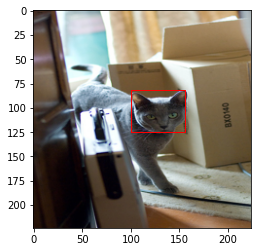

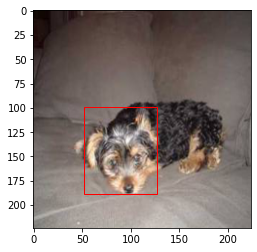

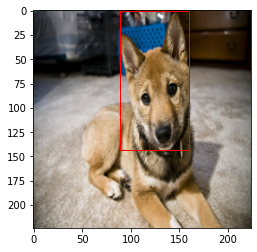

In [73]:
# _parse_function() 반환값 : image, ground_truth(x,y,w,h)
for image, gt in val_dataset.take(3): # 반복 3번  - 한번 박복할때마다 N번째 배치값을 조회
    
    '''그림을 그리기 위해서 bbox의 왼쪽 위 꼭지점 좌표를 계산하고, 
    xmin, ymin, w, h 각각을 image size에 맞게 scaling'''
    x = gt[:,0]  #(배치사이즈 40) 반환된 ground truth의 0번축 = x ,,.....
    y = gt[:,1]  # x, y 는 센터 값이다.
    w = gt[:,2] 
    h = gt[:,3] 
    xmin = x[0].numpy() - w[0].numpy()/2.    # 배치사이즈 40개 반환되는 이미지 중에 0번째것만 갖고 그리겠다는 것이다.
    ymin = y[0].numpy() - h[0].numpy()/2. # y센터에서 height/2 한 값을 빼면 ymin 이된다.
    # 조회된 xmin, ymin , w, h 는 0~1로 normalize된 값(이미지의 width, height에대한 비율화 됐으니까..)
    
    #--> 원래 크기(값)으로 복원, x,w는 이미지 width 곱하고 , y,h는 이미지height를 곱한다.(이미지를 224X224로 resize했으므로 IMG_SIZE(224)로 곱한다)
    #원래값으로 복원해서 좌표에 넣어줘야한다. 
    rect_x = int(xmin * IMG_SIZE)   # 비율이였으니까 re
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[0].numpy() * IMG_SIZE)
    rect_h = int(h[0].numpy() * IMG_SIZE)
    
    # Rectagnle((xmin,ymin), box_width, box_height, fill = 색을 채울지여부 , color 선색)
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect) # axes에 도형붙이고
    plt.imshow(image[0])     # 이미지를 axes에 이미지 붙임 그래서 겹쳐보이게 하는 컨셉
    plt.show()

    # 첫번째 배치 중에 0번째 이미지, 두번째 배치중에 0번째,세번째 배치중 0번째 .. 

## 모델 생성 및 학습


In [48]:
from tensorflow.keras import optimizers
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow import keras

In [2]:
#include_top=False -> classification 부분 안갖고 오고 , / featureextraction부분반 갖고옴.. 분류는 직접 쌓아서 사용

In [35]:
def create_l_model():
    resnet101v2 = ResNet101V2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    model = keras.models.Sequential()
    # Feature Extraction
    model.add(resnet101v2)
    model.add(GlobalAveragePooling2D())
    # 추가 hidden
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(ReLU())
    # x,y,w,h -> unit 을 4, 각각 출력값이 0~1 사이의 값으로 normalize 되었으므로 출력 결과도 그 scale에 맞추기 위해 sigmoid 활성함수 사용.
    # localizaition 문제 (위치- 좌표, 너비, 높이 예측) -> 회귀 (Regression 문제)/ 좌표-> 숫자를 맞추는 .. 회귀문제 
    model.add(Dense(4, activation='sigmoid')) # 출력층 // ->sigmoid ㅇㅖ측한 값(x,y,w,h)들 0-1 사이로 만들어 주려고.. 
    return model

In [36]:
model = create_l_model()
model.summary()

171319296/171317808 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 7, 7, 2048)        42626560  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_______________________________________________________

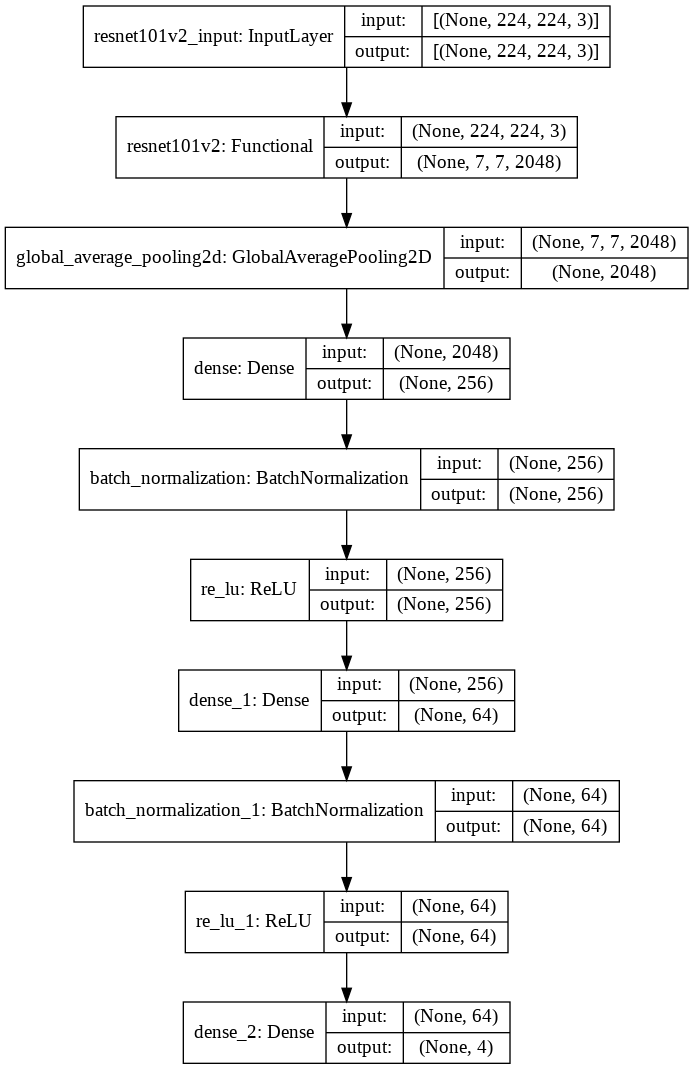

In [35]:
keras.utils.plot_model(model, show_shapes= True)

In [37]:
# 모델 컴파일
## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=LEARNING_RATE, # 초기 learning rate
                                                          decay_steps=steps_per_epoch*10,      # 몇 step당 learning변경 (10에폭당.. )
                                                          decay_rate=0.5,   # 변경할 learningrate의 비율( 현재 learning_rate*decay_rate)
                                                          staircase=True)   # step마다 조금씩 변경할지 여부 
model.compile(optimizers.Adam(lr_schedule), loss="mse") # 회귀 문제이므로 Mean Squared Error 를 loss 함수로 지정

In [ ]:
# 학습 모델 저장 
# 학습도중 callback -1. 매에폭 결과 2. 성능 제일 좋았던 결과
# 학습도중 saveweight
N_EPOCHS = 2

filepath = r'/content/drive/MyDrive/save_models/oxford_pet_localization_resnet101v2_model' # 모델 저장을 위해서.. 
mc_callback = keras.callbacks.ModelCheckpoint(filepath, 'val_loss',verbose=1, save_best_only=True)  # val_loss 성능 제일 좋았던 모델의 상태 저장.
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1) # 모델의 성능이 개선이 안되면/ val_loss가 5번에폭동안 좋아지지않으면 스탑 

history = model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
                    epochs=N_EPOCHS,
                    validation_data=val_dataset,
                    validation_steps=validation_steps, 
                    callbacks=[mc_callback, es_callback])

In [ ]:
!nvidia-smi

## 확인

In [39]:
# 미리학습한 모델 다운로드  40epochs 한 것 
import gdown
url = 'https://drive.google.com/uc?id=1-2IbiHp3SdffxkqIj4iGL9-recS6g697'
fname = 'oxford_pet_localization_resnet101.tar.gz'
gdown.download(url, fname, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-2IbiHp3SdffxkqIj4iGL9-recS6g697
To: /content/oxford_pet_localization_resnet101.tar.gz
475MB [00:04, 96.5MB/s]


'oxford_pet_localization_resnet101.tar.gz'

In [40]:
!mkdir models

In [41]:
!tar -zxvf oxford_pet_localization_resnet101.tar.gz -C  models

oxford_pet_localization_resnet101v2_model/
oxford_pet_localization_resnet101v2_model/variables/
oxford_pet_localization_resnet101v2_model/variables/variables.index
oxford_pet_localization_resnet101v2_model/variables/variables.data-00000-of-00001
oxford_pet_localization_resnet101v2_model/assets/
oxford_pet_localization_resnet101v2_model/saved_model.pb


In [42]:
# 저장된 모델 load  -> 모델자체를 저장했었음
filepath = '/content/models/oxford_pet_localization_resnet101v2_model'
saved_model = keras.models.load_model(filepath)

In [43]:
saved_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 7, 7, 2048)        42626560  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                2

### Bounding Box 그리기

In [45]:
validation_steps

18

In [44]:
# 예측한 bounding box와 ground truth box를 image에 같이 표시
# 정답은 빨간색 box, 예측은 파란색 box
idx = 3
num_imgs = validation_steps
for val_data, val_gt in val_dataset.take(num_imgs):

    x = val_gt[:,0]
    y = val_gt[:,1]
    w = val_gt[:,2]
    h = val_gt[:,3]

    xmin = x[idx].numpy() - w[idx].numpy()/2.
    ymin = y[idx].numpy() - h[idx].numpy()/2.

    rect_x = int(xmin * IMG_SIZE)
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[idx].numpy() * IMG_SIZE)
    rect_h = int(h[idx].numpy() * IMG_SIZE)
    

    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)
    
    
    prediction = saved_model.predict(val_data)
    pred_x = prediction[:,0]
    pred_y = prediction[:,1]
    pred_w = prediction[:,2]
    pred_h = prediction[:,3]
    pred_xmin = pred_x[idx] - pred_w[idx]/2.
    pred_ymin = pred_y[idx] - pred_h[idx]/2.
    pred_rect_x = int(pred_xmin * IMG_SIZE)
    pred_rect_y = int(pred_ymin * IMG_SIZE)
    pred_rect_w = int(pred_w[idx] * IMG_SIZE)
    pred_rect_h = int(pred_h[idx] * IMG_SIZE)
    
    # 예측 바운딩 박스
    pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h,
                         fill=False, color='blue')
    plt.axes().add_patch(pred_rect)
    
    
    plt.imshow(val_data[idx])
    plt.show()
 


Output hidden; open in https://colab.research.google.com to view.

### IoU확인하기

In [49]:
## Valiation set의 IOU 계산
avg_iou = 0
num_imgs = validation_steps  # 1에폭당 업데이트 되는 횟수 -> 즉 1에폭당 몇개의 배치들이 들어가나.. 
res = N_VAL % N_BATCH #N_VAL : validation data 개수 % batch_size -> 마지막 배치의 데이터 개수 
for i, (val_data, val_gt) in enumerate(val_dataset.take(num_imgs)):
    # flag: true - 마지막 배치의 데이터 iou처리, False- 중간 배치들ㅇ 데이터에 대한 iou 처리 ->5교시
    flag = (i == validation_steps-1) # i 0~ : 현재 반복 횟수 - 몇번째 배치에 대한 처리. ///(validation_step-1):마지막 배치 순번 / i가 0부터니까 -1함

    # ground Truth 의 x,y,w,h 조회
    x = val_gt[:,0]
    y = val_gt[:,1]
    w = val_gt[:,2]
    h = val_gt[:,3]

    # predict 
    prediction = saved_model.predict(val_data)
    # 예측결과 : x,y,w,h
    pred_x = prediction[:,0]
    pred_y = prediction[:,1]
    pred_w = prediction[:,2]
    pred_h = prediction[:,3]
    for idx in range(N_BATCH):  #0~39 배치 사이즈가 40 이고 각각의 것들의 iou를 구할거니까 // 
    #제일 마지막 짜투리 배치를 돌릴때 인덱스번호와 차투리 배치의 인덱스번호(res) 가 같으면 반복문그만 
        if flag:  # True면 마지막 배치 처리
            if idx == res: # True : 마지막 배치의 모든 데이터에 대한 iou 계산이 끝났다.
                flag = False
                break  
        # 1개 이미지에 대한 IoU값 계산 
        
        # gt 박스, pred 박스 그릴 좌표
        xmin = int((x[idx].numpy() - w[idx].numpy()/2.)*IMG_SIZE) # x는 센터 값이니까 w/2한거를 빼면  xmin
        ymin = int((y[idx].numpy() - h[idx].numpy()/2.)*IMG_SIZE)
        xmax = int((x[idx].numpy() + w[idx].numpy()/2.)*IMG_SIZE)# x는 센터 값이니까 w/2한거를 더하면면  xmax -> y도 마찬가지
        ymax = int((y[idx].numpy() + h[idx].numpy()/2.)*IMG_SIZE)
        
        pred_xmin = int((pred_x[idx] - pred_w[idx]/2.)*IMG_SIZE)
        pred_ymin = int((pred_y[idx] - pred_h[idx]/2.)*IMG_SIZE)
        pred_xmax = int((pred_x[idx] + pred_w[idx]/2.)*IMG_SIZE)
        pred_ymax = int((pred_y[idx] + pred_h[idx]/2.)*IMG_SIZE)
        # 두개 bbox가 겹치지 않는경우. .. // 겹치지 않는다면 밑에 계산 안하고 continue
        if xmin > pred_xmax or xmax < pred_xmin:        
            continue
        if ymin > pred_ymax or ymax < pred_ymin:        
            continue
        
        gt_width = xmax-xmin
        gt_height = ymax - ymin
        pred_width = pred_xmax - pred_xmin
        pred_height = pred_ymax - pred_ymin
        
        # 교집합 영역의 width , height 구하기 .
        # max : 둘중에 작은값 , min:둘중에 큰값
        inter_width  =  np.min((xmax, pred_xmax)) - np.max((xmin, pred_xmin))
        inter_height = np.min((ymax, pred_ymax)) - np.max((ymin, pred_ymin))
  
 
        iou = (inter_width * inter_height)/((gt_width * gt_height) + (pred_width * pred_height) - (inter_width * inter_height))

        avg_iou += iou / N_VAL # 각각의 iou값을 validation 데이터 개수로 나눔눈 것을 더하고 그것을 반복하면 총 validation data의 iou 평균이나옴

print(avg_iou)

0.7585194406896107


# Classification을 추가하여 Multi-task Learning으로 Localization 학습하기

- **고양이/개 2개 class로 classification**

In [51]:
from tensorflow.keras import optimizers
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow import keras

In [52]:
#tfrecord 파싱 함수(classification + localization)
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64),
              'bi_cls_num': tf.io.FixedLenFeature([], tf.int64),
              'x': tf.io.FixedLenFeature([], tf.float32),
              'y': tf.io.FixedLenFeature([], tf.float32),
              'w': tf.io.FixedLenFeature([], tf.float32),
              'h': tf.io.FixedLenFeature([], tf.float32)              
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255.

    cls_label = tf.cast(parsed_features['cls_num'], tf.float32) # 0,1 인..
    bi_cls_label = tf.cast(parsed_features['bi_cls_num'], tf.float32)
    
    x = tf.cast(parsed_features['x'], tf.float32)
    y = tf.cast(parsed_features['y'], tf.float32)
    w = tf.cast(parsed_features['w'], tf.float32)
    h = tf.cast(parsed_features['h'], tf.float32)
    ground_truth = tf.stack([bi_cls_label, x, y, w, h], -1) 
    
    return image, ground_truth

In [58]:
#Train Dataset 생성
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [59]:
#Validation Dataset 생성
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

In [60]:
# functional 로 모델 만듦 
def create_cl_model():    
    resnet101v2 = ResNet101V2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    gap = GlobalAveragePooling2D()(resnet101v2.output)  # resnet101v2.output -> output 통과해서 나온 값

    # classification
    dense_b1_1 = Dense(256)(gap)  # 따로 따로 전달 
    bn_b1_2 = BatchNormalization()(dense_b1_1)
    relu_b1_3 = ReLU()(bn_b1_2)
    dense_b1_4 = Dense(64)(relu_b1_3)
    bn_b1_5 = BatchNormalization()(dense_b1_4)
    relu_b1_6 = ReLU()(bn_b1_5)
    output1 = Dense(2, activation='softmax', name='output1')(relu_b1_6)# classification 의 출력(2진 분류지만  -> 다중분류결과로 dog일확률, cat일확률)

    # localization 
    dense_b2_1 = Dense(256)(gap)
    bn_b2_2 = BatchNormalization()(dense_b2_1)
    relu_b2_3 = ReLU()(bn_b2_2)
    dense_b2_4 = Dense(64)(relu_b2_3)
    bn_b2_5 = BatchNormalization()(dense_b2_4)
    relu_b2_6 = ReLU()(bn_b2_5)
    output2 = Dense(4, activation='sigmoid', name='output2')(relu_b2_6)#localization의 출력. 좌표 0~1 normalization 되어잇으므로 scale을 맞추기위해 sigmod 사용.
    
    concat = Concatenate(name='finaly_output')([output1, output2]) #Concatenate ->layer에 잇는 메서드 concat과 같은 역할.. 
    return keras.Model(inputs=resnet101v2.input, outputs=concat)

In [65]:
model = create_cl_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [70]:
# Loss 함수 구현 - 두가지 종류 다중분류와 회귀를 합치기 때문에 loss함수를 만들어야한다.-복합적.. 
def loss_fn(y_true, y_pred):
    """
    [매개변수]
         y_true : ndarray- ground truth(정답), 
         y_pred : ndarray- 모델이 예측한 결과
    [반환값]
        실수(float) - y_true와 y_pred 사이의 오차

    """
    cls_labels = tf.cast(y_true[:,:1], tf.int64)#Ground Truth의 분류관련 y값(index 0)/one hot encoding 안됨/ 배치 40개니까 다갖고 오고 , 0번인덱스만 / ground truth 는 하나의 데이터에 5개가 나옴 첫번째는 개,고양이 분류/ 나머지는 좌표 4개 
    # cls_labels 는  총 5개의 원소를 가진 값으로 나오고 그중 제일 앞에 0번째 값이 개,고양이 구분값이다. 나머지는 좌표값
    loc_labels = y_true[:,1:] # Ground Truth 의 x,y,w,h좌표.

    cls_preds = y_pred[:,:2] # pred classification / 값이 2개로 나오니까..
    # pred 는 총 6개의 원소를 가진 값으로 나오고 그중 앞의 두개의 값 0,1번째 값이 고양이, 개일 확률을 반환한다. 나머지 좌표값. 
    loc_preds = y_pred[:,2:] # pred x,y,w,h좌표 값
    cls_loss = tf.keras.losses.SparseCategoricalCrossentropy()(cls_labels, cls_preds) # SparseCategoricalCrossentropy() 원핫인코딩때문에..
    loc_loss = tf.keras.losses.MeanSquaredError()(loc_labels, loc_preds)
    return cls_loss + 5*loc_loss # 구현된 함수들을 갖고와서 각각 로스를 구하게 하고 더한다...
    # loc_loss에 가중치(중요도)를 주고 싶은 경우... *5를 한것이다. -> 둘중 더 중요하게 하고 싶은경우..

In [89]:
# 모델 컴파일
## learning rate scheduling
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=LEARNING_RATE,
                                                          decay_steps=steps_per_epoch*10,
                                                          decay_rate=0.5,
                                                          staircase=True)
model.compile(optimizers.Adam(lr_schedule), loss=loss_fn)

In [72]:
# 학습
filepath2 = r'/content/drive/MyDrive/save_models/oxford_pet_localization_classification_resnet101v2_weights/oxford_pet_lc_weights.ckpt'
mc_callback = keras.callbacks.ModelCheckpoint(filepath2, 'val_loss',verbose=1, save_best_only=True, save_weights_only=True)
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
N_EPOCHS = 1
history = model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
                    epochs=N_EPOCHS,
                    validation_data=val_dataset,
                    validation_steps=validation_steps,
                    callbacks=[mc_callback, es_callback])

75/75 [==============================] - 60s 662ms/step - loss: 0.0692 - val_loss: 0.2567

Epoch 00001: val_loss improved from inf to 0.25672, saving model to /content/drive/MyDrive/save_models/oxford_pet_localization_classification_resnet101v2_weights/oxford_pet_lc_weights.ckpt


# 확인

### 미리 학습된 weights 가져오기 평가하기

In [73]:
# 미리학습한 모델 다운로드
import gdown
url = 'https://drive.google.com/uc?id=1ycRNri9Gr6QjcOFv4GQi_DLCU17JbOyo'
fname = 'oxford_pet_classification_localization_resnet101_weight.tar.gz'
gdown.download(url, fname, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ycRNri9Gr6QjcOFv4GQi_DLCU17JbOyo
To: /content/oxford_pet_classification_localization_resnet101_weight.tar.gz
481MB [00:04, 113MB/s]


'oxford_pet_classification_localization_resnet101_weight.tar.gz'

In [75]:
#!mkdir models

mkdir: cannot create directory ‘models’: File exists


In [74]:
# 압축풀기
!tar -zxvf oxford_pet_classification_localization_resnet101_weight.tar.gz -C  models

oxford_pet_localization_classification_resnet101v2_weights/
oxford_pet_localization_classification_resnet101v2_weights/oxford_pet_lc_weights.ckpt.index
oxford_pet_localization_classification_resnet101v2_weights/checkpoint
oxford_pet_localization_classification_resnet101v2_weights/oxford_pet_lc_weights.ckpt.data-00000-of-00001


In [76]:
# 마지막으로 저장된 checkpoint 경로 확인 -> 베스트만 저장하는거니까
best_weight_path = tf.train.latest_checkpoint('/content/models/oxford_pet_localization_classification_resnet101v2_weights')
best_weight_path

'/content/models/oxford_pet_localization_classification_resnet101v2_weights/oxford_pet_lc_weights.ckpt'

In [77]:
# 저장된 weight load 
saved_model2 = create_cl_model()
saved_model2.load_weights(best_weight_path) # 저장된 weight를 학습 저장된 모델에 넣어준다.

### Bounding Box 확인

In [ ]:
# 배치중 idx번째 것만 확인
idx = 1
num_imgs = validation_steps 
for val_data, val_gt in val_dataset.take(num_imgs):
    
   
    gt_cls_name = np.where(val_gt[:,0]==0,'dog','cat')
    
    x = val_gt[:,1]
    y = val_gt[:,2]
    w = val_gt[:,3]
    h = val_gt[:,4]
    xmin = x[idx].numpy() - w[idx].numpy()/2.
    ymin = y[idx].numpy() - h[idx].numpy()/2.
    rect_x = int(xmin * IMG_SIZE)
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[idx].numpy() * IMG_SIZE)
    rect_h = int(h[idx].numpy() * IMG_SIZE)
    
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)    
    
    prediction = saved_model2.predict(val_data)
    
    pred_cls_idx = np.argmax(prediction[:,:2], axis=-1)
    pred_cls_name = np.where(pred_cls_idx==0, 'dog','cat')
    
    pred_x = prediction[:,2]
    pred_y = prediction[:,3]
    pred_w = prediction[:,4]
    pred_h = prediction[:,5]
    pred_xmin = pred_x[idx] - pred_w[idx]/2.
    pred_ymin = pred_y[idx] - pred_h[idx]/2.
    pred_rect_x = int(pred_xmin * IMG_SIZE)
    pred_rect_y = int(pred_ymin * IMG_SIZE)
    pred_rect_w = int(pred_w[idx] * IMG_SIZE)
    pred_rect_h = int(pred_h[idx] * IMG_SIZE)
    
    pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h,
                         fill=False, color='blue')
    plt.axes().add_patch(pred_rect)
    plt.title(f'Ground Truth-{gt_cls_name[idx]}, Pred:{pred_cls_name[idx]}')
    
    plt.imshow(val_data[idx])
    plt.show()

### IoU 계산

In [81]:
avg_iou = 0
num_imgs = validation_steps
res = N_VAL % N_BATCH
for i, (val_data, val_gt) in enumerate(val_dataset.take(num_imgs)):    
    flag = (i == validation_steps-1)
    x = val_gt[:,1]
    y = val_gt[:,2]
    w = val_gt[:,3]
    h = val_gt[:,4]

    prediction = saved_model2.predict(val_data)
    
    pred_x = prediction[:,2]
    pred_y = prediction[:,3]
    pred_w = prediction[:,4]
    pred_h = prediction[:,5]
    for idx in range(N_BATCH):
        if(flag):
            if idx == res:
                flag = False
                break          
        xmin = int((x[idx].numpy() - w[idx].numpy()/2.)*IMG_SIZE)
        ymin = int((y[idx].numpy() - h[idx].numpy()/2.)*IMG_SIZE)
        xmax = int((x[idx].numpy() + w[idx].numpy()/2.)*IMG_SIZE)
        ymax = int((y[idx].numpy() + h[idx].numpy()/2.)*IMG_SIZE)
        
        pred_xmin = int((pred_x[idx] - pred_w[idx]/2.)*IMG_SIZE)
        pred_ymin = int((pred_y[idx] - pred_h[idx]/2.)*IMG_SIZE)
        pred_xmax = int((pred_x[idx] + pred_w[idx]/2.)*IMG_SIZE)
        pred_ymax = int((pred_y[idx] + pred_h[idx]/2.)*IMG_SIZE)
 
        if xmin > pred_xmax or xmax < pred_xmin:        
            continue
        if ymin > pred_ymax or ymax < pred_ymin:        
            continue
        
        gt_width = xmax-xmin
        gt_height = ymax - ymin
        pred_width = pred_xmax - pred_xmin
        pred_height = pred_ymax - pred_ymin
 
        inter_width  =  np.min((xmax, pred_xmax)) - np.max((xmin, pred_xmin))
        inter_height = np.min((ymax, pred_ymax)) - np.max((ymin, pred_ymin))
  
 
        iou = (inter_width * inter_height)/((gt_width * gt_height) + (pred_width * pred_height) - (inter_width * inter_height))
        avg_iou += iou / N_VAL
        
print(avg_iou)

0.8301395356589137


# 새로운 Image로 Test하기

In [85]:
from PIL import Image
image = Image.open('cat.jpg')
image = image.resize((224, 224))
image = np.array(image)
image = image/255.
image = image[np.newaxis, ...]
print(image.shape)

(1, 224, 224, 3)


cat


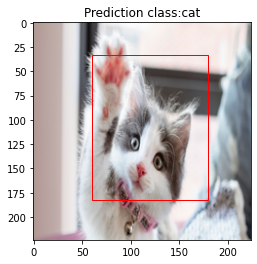

In [86]:
# 예측 결과 확인 - bounding box, class
from matplotlib.patches import Rectangle
prediction = saved_model2.predict(image)
pred_cls = np.where(np.argmax(prediction[0,:2], axis=-1)==0, 'dog', 'cat')
print(pred_cls)
pred_x = prediction[0,2]
pred_y = prediction[0,3]
pred_w = prediction[0,4]
pred_h = prediction[0,5]
pred_xmin = pred_x - pred_w/2.
pred_ymin = pred_y - pred_h/2.
pred_rect_x = int(pred_xmin * IMG_SIZE)
pred_rect_y = int(pred_ymin * IMG_SIZE)
pred_rect_w = int(pred_w * IMG_SIZE)
pred_rect_h = int(pred_h * IMG_SIZE)

pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h,
                       fill=False, color='red')
plt.axes().add_patch(pred_rect)

import matplotlib.pyplot as plt
plt.imshow(image[0])
plt.title(f'Prediction class:{pred_cls}')
plt.show()